In [9]:
import math
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from sklearn.metrics import silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans, TimeSeriesCentroidBasedClusteringMixin
from IPython.display import display, Image

In [4]:
data = pd.read_csv("dataset_historique_consommation_francaise.csv", parse_dates=["Date"], index_col="Date")
data.head()

,Consommations
Date,
2017-12-31 23:00:00,58882
2017-12-31 23:15:00,58849
2017-12-31 23:30:00,57677
2017-12-31 23:45:00,56520
2018-01-01 00:00:00,55957


In [5]:
data.index.min(), data.index.max()

(Timestamp('2017-12-31 23:00:00'), Timestamp('2025-05-02 21:45:00'))

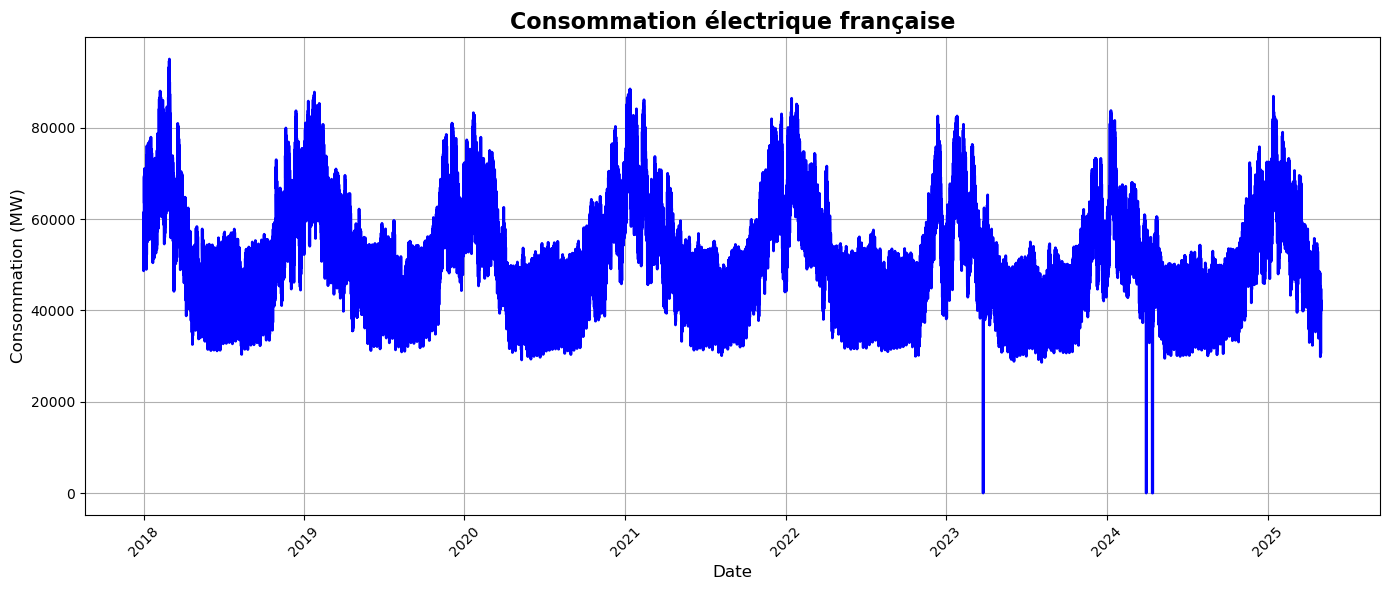

In [7]:
plt.figure(figsize=(14, 6))

# Courbe principale
plt.plot(data.index, data["Consommations"], color="blue", linewidth=2)

# Titres et labels
plt.title("Consommation électrique française", fontsize=16, fontweight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Consommation (MW)", fontsize=12)

# Grille
plt.grid(True)

# Style général
plt.xticks(rotation=45)
plt.tight_layout()  # pour éviter les chevauchements
plt.show()

In [14]:
# Complétion des valeurs nulles
data["Consommations"] .replace(0.0, np.nan, inplace=True)
data.fillna(value=data.interpolate(method='linear'), inplace=True)

C:\Users\saida\AppData\Local\Temp\ipykernel_16184\1793422459.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [15]:
df = data.copy()
df = df.resample("h").mean()
df["Heures"] = df.index.time
df["Jours"] = df.index.day_of_year

C:\Users\saida\AppData\Local\Temp\ipykernel_16184\3597646042.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




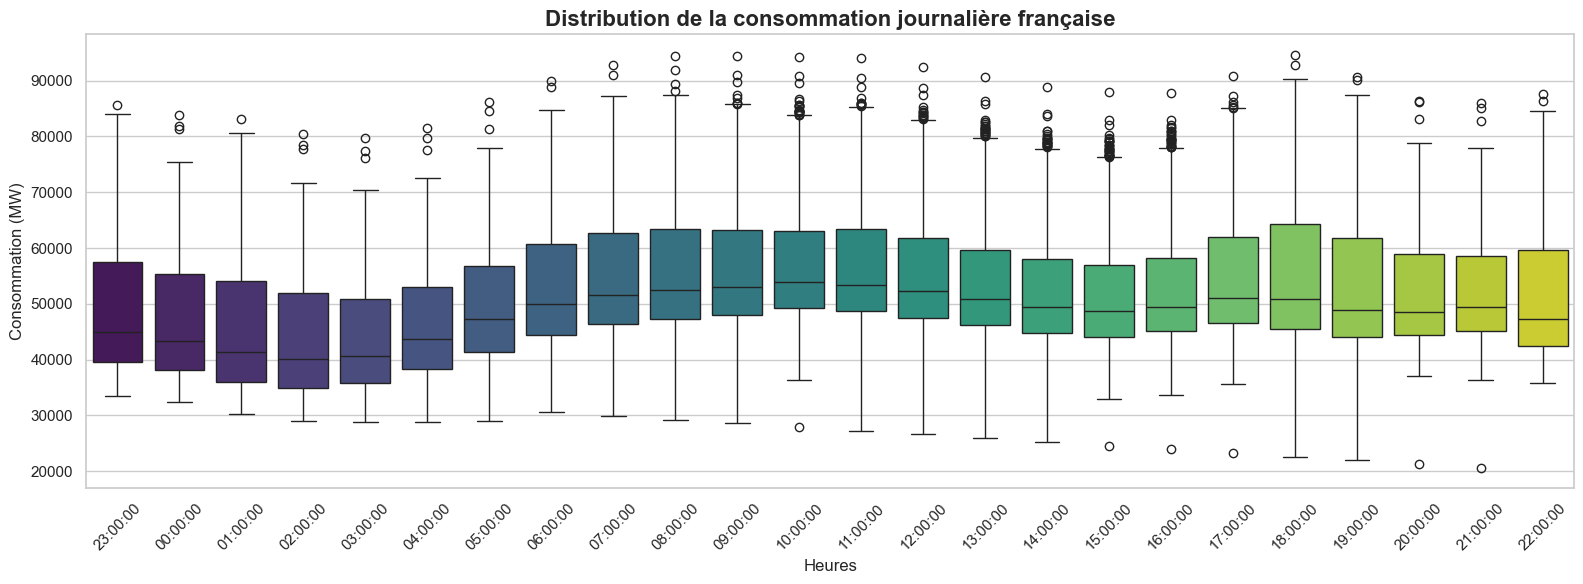

In [16]:
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")

sns.boxplot(data=df, x="Heures", y="Consommations", palette="viridis")
plt.title("Distribution de la consommation journalière française", fontsize=16, fontweight="bold")
plt.xlabel("Heures", fontsize=12)
plt.ylabel("Consommation (MW)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
series = df.pivot_table(values="Consommations", index="Jours", columns="Heures")
series.head()

Heures,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
Jours,,,,,,,,,,,,,,,,,,,,,
1,56780.65625,55744.93750,52835.43750,50648.78125,50071.81250,50376.00000,50835.40625,51041.59375,51586.96875,53096.40625,...,52849.81250,52455.68750,54944.68750,58537.34375,60086.03125,58939.65625,57002.87500,56971.84375,58042.18750,56134.68750
2,53754.75000,52848.75000,50585.65625,49568.81250,50795.96875,53689.56250,56799.65625,59525.31250,61420.78125,63026.68750,...,61381.59375,60581.31250,62469.34375,65702.31250,66775.09375,63969.87500,60856.56250,60248.37500,61302.03125,59229.56250
3,56638.50000,55645.34375,53244.00000,52081.78125,53479.40625,57135.37500,61204.68750,64274.87500,65709.75000,66536.21875,...,63041.50000,62376.78125,64676.03125,68348.96875,69436.71875,66447.65625,63092.43750,62414.71875,63404.68750,61440.21875
4,58865.40625,57861.56250,55440.62500,54355.65625,55740.71875,59278.09375,63518.06250,66591.59375,67879.00000,68639.09375,...,64832.68750,63972.46875,65898.96875,69305.87500,70076.53125,66805.59375,63462.06250,62822.75000,63726.40625,61697.37500
5,59090.90625,58049.00000,55459.50000,54194.15625,55224.53125,58376.21875,62107.81250,64819.15625,66190.37500,67051.90625,...,63406.18750,62648.03125,64672.81250,68559.15625,69692.21875,66765.18750,63576.65625,62948.68750,63919.56250,61996.65625


In [18]:
scaler = TimeSeriesScalerMeanVariance()
X = scaler.fit_transform(series.values)
X.shape

(366, 24, 1)

In [19]:
K = range(2, 11)
scores = []
for k in K:
    
    model = TimeSeriesKMeans(n_clusters=k)
    y_pred = model.fit_predict(X)
    y_pred = y_pred.reshape(-1)
    scores.append(silhouette_score(X.reshape(-1, 24), y_pred))


In [20]:
scores

[0.35594774872376567,
 0.373591856219998,
 0.4109700075821535,
 0.38366692266195035,
 0.4070755952027308,
 0.35786392278721496,
 0.39055656768001523,
 0.3892198079108595,
 0.3251262339631117]

In [34]:
optimal_cluster = K[np.argmax(scores)]
print(f"Meilleur nombre optimal de cluster : {optimal_cluster}")

Meilleur nombre optimal de cluster : 4


In [35]:
optimal_cluster=optimal_cluster
model = TimeSeriesKMeans(n_clusters=optimal_cluster)
y_pred = model.fit_predict(X)
y_pred = y_pred.reshape(-1)

In [36]:
representant = model.cluster_centers_

In [37]:
representant=representant.reshape(-1, 24)

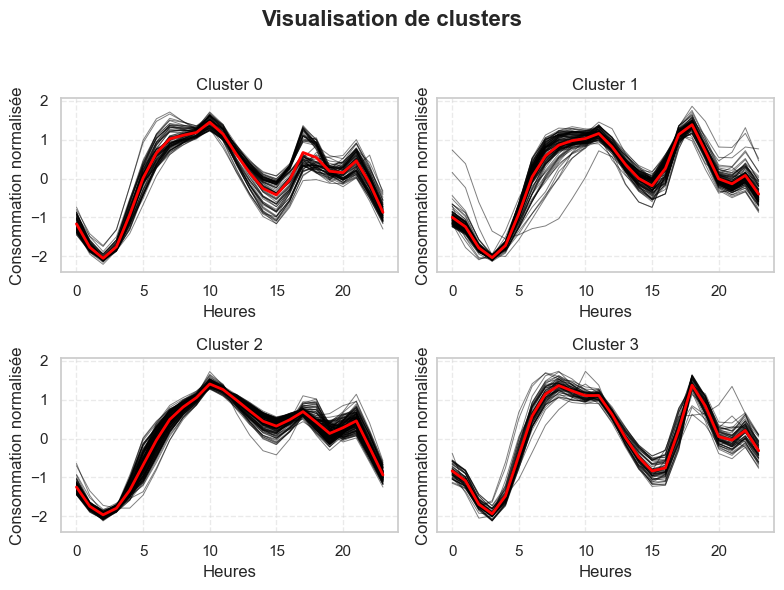

In [40]:
rows = math.ceil(np.sqrt(optimal_cluster))
cols = math.ceil(optimal_cluster / rows)

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows), sharey=True)
axes = axes.flatten() 

fig.suptitle("Visualisation de clusters", fontsize=16, fontweight="bold")

for i in range(optimal_cluster):
    ax = axes[i]

    for xx in X[y_pred == i]:
        ax.plot(np.arange(24), xx.ravel(), color="black", linewidth=0.7, alpha=0.5)

    ax.plot(np.arange(24), representant[i].ravel(), color="red", linewidth=2, label="Centre")

    ax.set_title(f"Cluster {i}", fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.4)

    
    ax.set_ylabel("Consommation normalisée")
    ax.set_xlabel("Heures")

for j in range(optimal_cluster, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()

In [46]:
for i in range(optimal_cluster):
    print(f"cluster {i} représente {len(y_pred[y_pred==i])} jour(s) de l'année")

cluster 0 représente 71 jour(s) de l'année
cluster 1 représente 103 jour(s) de l'année
cluster 2 représente 138 jour(s) de l'année
cluster 3 représente 54 jour(s) de l'année
